# **Tutoriel : le paradigme columnar avec ClickHouse**

### **Introduction**

Bienvenue dans notre tutoriel sur le moteur de base de données Clickhouse, basé sur le paradigme columnar. Ce tutoriel permet de présenter le paradigme columnar, d'étudier ses spécificités, ses atouts et ses limites. A cette fin, il vous est proposé de travailler sur un ensemble de données des taxis de la ville de New York. Vous allez manipuler ces données à la fois avec un moteur classique en MySQL et avec un moteur en columnar grâce à ClickHouse, avec pour objectif de faire la comparaison entre les deux approches pour mettre en valeur les singularités du paradigme columnar.

Dans la majorité des bases de données relationelles, les données sont structurées et conservées sous forme de lignes. Pour chaque ligne il y a une clé primaire à laquelle sont associées des propriétés. Dans le cas du paradigme columnar, les données sont conservées sous forme de colonnes et non de lignes.
Pour illustrer cette distinction entre les deux approches, ci-dessous un exemple tiré de notre jeu de données.


| ID    | Passenger Count  | Trip Distance  | Total amount  |
| ----- | ---------------- | -------------- | ------------- |
| 0     | 1                | 18             | 50            |
| 1     | 2                | 3              | 8             |
| 2     | 1                | 7              | 17            |
| 3     | 4                | 10             | 32            |

Dans une base de données orientée lignes, les données ci-dessus sont stockées selon les lignes :

(0, 1, 18, 50) ; (1, 2, 3, 8) ; (2, 1, 7, 17) ; (3, 4, 10, 32).

Tandis que dans une base de données columnar, la rétention se fait selon les colonnes :

(0, 1, 2, 3) ; (1, 2, 1, 4) ; (18, 3, 7, 10) ; (50, 8, 17, 32).

### **Mise en place**

Pour commencer, il faut créer et démarrer les conteneurs encapsulant les différents composants nécessaires pour ce tutoriel, avec une commande `docker compose up`.

Ensuite il faut se connecter au serveur Jupyter accessible à l'adresse http://localhost:8888.

Enfin il faut configurer les connecteurs pour interagir avec les moteurs MySQL et ClickHouse. `conn` est le connecteur MySQL tandis que `client` est le client ClickHouse.

In [20]:
import pandas as pd
import time
from utils import test_mysql, test_clickhouse, sql_query, conn, client
import matplotlib.pyplot as plt
import numpy as np

### **Vérification des conteneurs**

Exécutez les blocs ci-dessous pour valider la bonne connection avec les conteneurs de moteurs de base de données.

In [2]:
# Le résultat attendu est "MySQL : (1, 'test', 100)"
test_mysql()

MySQL : (1, 'test', 100)


In [3]:
# Le résultat attendu est "ClickHouse : (1, 'test', 100)"
test_clickhouse()

ClickHouse : (1, 'test', 100)


Chargement du jeu de données avec les informations sur des trajets de taxi à New York.
Le jeu de données a été réduit à 50 000 données.

In [5]:
df = pd.read_csv(
    "./dataset/input_data.csv",
    usecols=[
        "VendorID",
        "passenger_count",
        "trip_distance",
        "fare_amount",
        "tip_amount",
        "tolls_amount",
    ],
)

## Découverte de la syntaxe

`client.command(query)` permet d'effectuer les opérations sur les tables (création, destruction).

In [6]:
client.command("DROP TABLE IF EXISTS dnd;")
client.command("""
    CREATE TABLE dnd (
        id UInt32,
        name VARCHAR(24),
        age UInt8,
        strengh Float32,
        charisma Float32,
        agility Float32,
        intelligence Float32
    ) ENGINE = MergeTree()
    ORDER BY id;
""")

`client.insert(table, data)` permet d'ajouter un ensemble de données à une table, où `data` prend la forme d'une liste de tuples représentant un tableau.

`data = [(...), (...), ...]`

In [7]:
data = [
    (1, "Alice", 23, 60, 80, 50, 55),
    (2, "Bob", 24, 60, 75, 65, 45),
    (3, "Charlie", 23, 90, 60, 45, 50),
    (4, "David", 23, 70, 70, 55, 50),
    (5, "Eleanore", 22, 60, 80, 40, 65),
]
client.insert("dnd", data)

`client.query(query)` permet d'effectuer une requête pour obtenir des données

In [8]:
result = client.query("SELECT * FROM dnd")

## Comparaison 1 : Chargement des données

In [9]:
NB_ROWS_TO_INSERT = 5000

On charge `NB_ROWS_TO_INSERT` données une par une pour étudier le temps mis par chaque système pour les ajouter.

In [13]:
# MySQL
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS nyc_taxi;")

cursor.execute("""
    CREATE TABLE nyc_taxi (
        id INT AUTO_INCREMENT PRIMARY KEY,
        vendor_id INT,
        passenger_count INT,
        trip_distance FLOAT,
        fare_amount FLOAT,
        tip_amount FLOAT,
        tolls_amount FLOAT
    );
""")

conn.commit()

t0_mysql = time.time()  # Start timing for MySQL
for i, row in df.iterrows():
    cursor.execute("""
        INSERT INTO nyc_taxi (vendor_id, passenger_count, trip_distance, fare_amount, tip_amount, tolls_amount)
        VALUES (%s, %s, %s, %s, %s, %s)
    """, tuple(row))
    conn.commit()
    if i == NB_ROWS_TO_INSERT:
        break
t1_mysql = time.time()  # End timing for MySQL
mysql_time = t1_mysql - t0_mysql  # Compute execution time

print("MySQL - Time required to add %d rows one by one : " % (NB_ROWS_TO_INSERT), mysql_time)

cursor.close()

MySQL - Time required to add 5000 rows one by one :  44.982691287994385


True

In [14]:
# ClickHouse
client.command("DROP TABLE IF EXISTS nyc_taxi;")

client.command("""
    CREATE TABLE nyc_taxi (
        id UInt32,
        vendor_id UInt8,
        passenger_count UInt8,
        trip_distance Float32,
        fare_amount Float32,
        tip_amount Float32,
        tolls_amount Float32
    ) ENGINE = MergeTree()
    ORDER BY id;
""")

t0_clickhouse = time.time()  # Start timing for ClickHouse
for i, row in df.iterrows():
    client.insert("nyc_taxi", [(i, row["VendorID"], row["passenger_count"], row["trip_distance"], row["fare_amount"], row["tip_amount"], row["tolls_amount"])])
    if i == NB_ROWS_TO_INSERT:
        break
t1_clickhouse = time.time()  # End timing for ClickHouse
clickhouse_time = t1_clickhouse - t0_clickhouse  # Compute execution time

print("ClickHouse - Time required to add %d rows one by one : " % (NB_ROWS_TO_INSERT), clickhouse_time)

ClickHouse - Time required to add 5000 rows one by one :  18.917097330093384


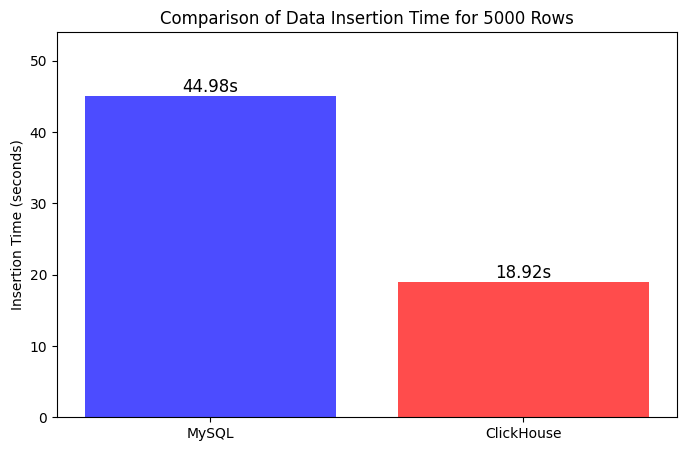

In [16]:
import matplotlib.pyplot as plt

databases = ["MySQL", "ClickHouse"]
times = [mysql_time, clickhouse_time]

plt.figure(figsize=(8, 5))
plt.bar(databases, times, color=['blue', 'red'], alpha=0.7)
plt.ylabel("Insertion Time (seconds)")
plt.title(f"Comparison of Data Insertion Time for {NB_ROWS_TO_INSERT} Rows")
plt.ylim(0, max(times) * 1.2)  # Adjust y-axis for visibility
plt.text(0, mysql_time, f"{mysql_time:.2f}s", ha='center', va='bottom', fontsize=12)
plt.text(1, clickhouse_time, f"{clickhouse_time:.2f}s", ha='center', va='bottom', fontsize=12)

plt.show()

On observe que ClickHouse est beaucoup plus lent que MySQL pour l'insertion des données.
Cela est dû à la différence dans la façon de conserver les données.
- Pour MySQL, on ajoute 1 liste de N éléments
- Pour ClickHouse, on ajoute 1 élement dans N listes

Afin de pallier ce problème, on utilise la fonction `insert` avec un tableau de données pour ajouter un paquet plutôt que des données une par une.

Ajoutez à présent l'ensemble des données dans les deux bases de données (cela devrait prendre quelques minutes).

In [17]:
# MySQL
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS nyc_taxi;")

cursor.execute("""
    CREATE TABLE nyc_taxi (
        id INT AUTO_INCREMENT PRIMARY KEY,
        vendor_id INT,
        passenger_count INT,
        trip_distance FLOAT,
        fare_amount FLOAT,
        tip_amount FLOAT,
        tolls_amount FLOAT
    );
""")

conn.commit()

for i, row in df.iterrows():
    cursor.execute("""
        INSERT INTO nyc_taxi (vendor_id, passenger_count, trip_distance, fare_amount, tip_amount, tolls_amount)
        VALUES (%s, %s, %s, %s, %s, %s)
    """, tuple(row))

conn.commit()
cursor.close()

True

In [18]:
# ClickHouse
client.command("DROP TABLE IF EXISTS nyc_taxi;")

client.command("""
    CREATE TABLE nyc_taxi (
        id UInt32,
        vendor_id UInt8,
        passenger_count UInt8,
        trip_distance Float32,
        fare_amount Float32,
        tip_amount Float32,
        tolls_amount Float32
    ) ENGINE = MergeTree()
    ORDER BY id;
""")

data = []
for i, row in df.iterrows():
    data.append([i, row["VendorID"], row["passenger_count"], row["trip_distance"], row["fare_amount"], row["tip_amount"], row["tolls_amount"]])

client.insert("nyc_taxi", data)

On voit ici qu'il y a un réel gain de temps lors de l'ajout par paquet.
L'ajout progressif des données est une limitation importante de ClickHouse et des bases de données orientées colonnes en général.

Vérifiez que les deux bases de données contiennent bien le même nombre de lignes.

In [19]:
result = sql_query("SELECT COUNT(*) FROM nyc_taxi;")
print("MySQL Total Rows:", result[0][0])

result = client.query("SELECT COUNT(*) FROM nyc_taxi;")
print("ClickHouse Total Rows:", result.result_rows[0][0])

MySQL Total Rows: 500000
ClickHouse Total Rows: 500000


## Comparaison 2 : Requêtes globales

On construit un jeu de requêtes pour étudier la différence dans le temps d'execution des requêtes selon la base de données. 

In [22]:
query_A = "SELECT * FROM nyc_taxi;"
query_B = "SELECT * FROM nyc_taxi ORDER BY passenger_count ASC, fare_amount DESC;"
query_C = "SELECT SUM(trip_distance) FROM nyc_taxi;"
query_D = "SELECT COUNT(*) FROM nyc_taxi;"
query_E = "SELECT COUNT(passenger_count) FROM nyc_taxi;"

queries = [query_A, query_B, query_C, query_D, query_E]
query_labels = ["SELECT *", "ORDER BY", "SUM", "COUNT", "COUNT column"]
iterations = 25

In [23]:
mysql_times = []
clickhouse_times = []

for query in queries:
    # Measure MySQL query execution time
    t0_mysql = time.time()
    for _ in range(iterations):
        resultsql = sql_query(query)
    t1_mysql = time.time()
    mysql_time = (t1_mysql - t0_mysql) / iterations  # Average time per query

    # Measure ClickHouse query execution time
    t0_clickhouse = time.time()
    for _ in range(iterations):
        resultcol = client.query(query)
    t1_clickhouse = time.time()
    clickhouse_time = (t1_clickhouse - t0_clickhouse) / iterations  # Average time per query

    # Store times for visualization
    mysql_times.append(mysql_time)
    clickhouse_times.append(clickhouse_time)

    # Print results
    print(f"Query: {query}")
    print(f"MySQL Time:      {mysql_time:.5f} seconds")
    print(f"ClickHouse Time: {clickhouse_time:.5f} seconds")
    print("-" * 50)

Query: SELECT * FROM nyc_taxi;
MySQL Time:      0.81213 seconds
ClickHouse Time: 0.08495 seconds
--------------------------------------------------
Query: SELECT * FROM nyc_taxi ORDER BY passenger_count ASC, fare_amount DESC;
MySQL Time:      1.02825 seconds
ClickHouse Time: 0.06811 seconds
--------------------------------------------------
Query: SELECT SUM(trip_distance) FROM nyc_taxi;
MySQL Time:      0.05497 seconds
ClickHouse Time: 0.00752 seconds
--------------------------------------------------
Query: SELECT COUNT(*) FROM nyc_taxi;
MySQL Time:      0.01104 seconds
ClickHouse Time: 0.00249 seconds
--------------------------------------------------
Query: SELECT COUNT(passenger_count) FROM nyc_taxi;
MySQL Time:      0.05246 seconds
ClickHouse Time: 0.00239 seconds
--------------------------------------------------


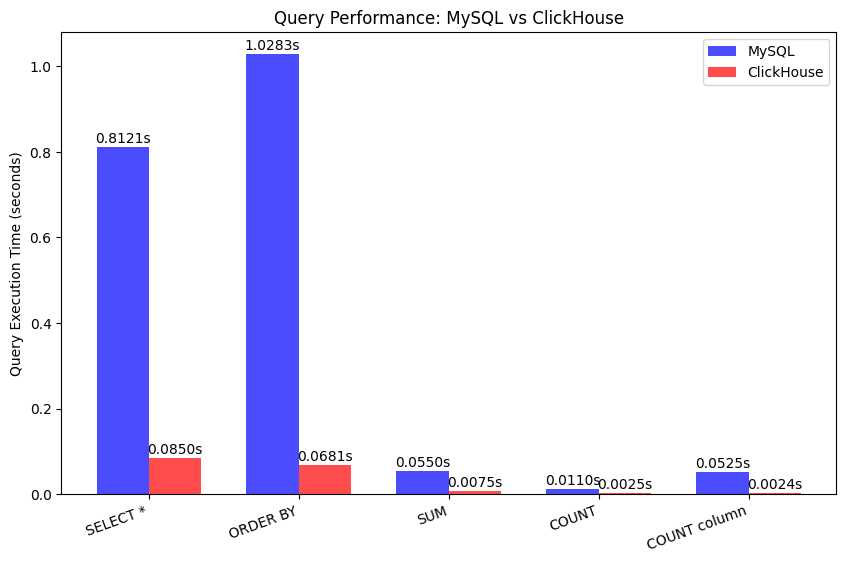

In [24]:
x = np.arange(len(query_labels))  # Label positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, mysql_times, width, label='MySQL', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, clickhouse_times, width, label='ClickHouse', color='red', alpha=0.7)

ax.set_ylabel('Query Execution Time (seconds)')
ax.set_title('Query Performance: MySQL vs ClickHouse')
ax.set_xticks(x)
ax.set_xticklabels(query_labels, rotation=20, ha="right")
ax.legend()

# Annotate bars with values
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}s', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}s', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

plt.show()

On constate que pour des requêtes globales, notamment les agrégations, ClickHouse est plus performant que MySQL. En effet, le paradigme columnar est particulièrement efficace pour traiter des requêtes ne nécessitant qu'un faible nombre de colonnes et faisant appel à des agrégations.

À présent à vous d'essayer de faire une requête pour comparer les performances des deux paradigmes.

In [17]:
query = "SELECT * FROM nyc_taxi;"
iterations = 25
t0 = time.time()
for i in range(iterations) :
    resultsql = sql_query(query)
t1 = time.time()
for i in range(iterations) :
    resultcol = client.query(query)
t2 = time.time()
print("Requête : ", query)
print("MySQL :      ", (t1 - t0)/iterations)
print("ClickHouse : ", (t2 - t1)/iterations)

Requête :  SELECT * FROM nyc_taxi;
MySQL :       0.7972306823730468
ClickHouse :  0.0843276023864746


## Comparaison 3 : Requêtes spécifiques

On étudie à présent le cas où l'on souhaite accéder à une ligne spécifique.

In [ ]:
query1 = "SELECT * FROM nyc_taxi WHERE id=1523"
iterations = 25

t0_mysql_1 = time.time()
for _ in range(iterations):
    resultsql = sql_query(query1)
t1_mysql_1 = time.time()
mysql_time_1 = (t1_mysql_1 - t0_mysql_1) / iterations

t0_clickhouse_1 = time.time()
for _ in range(iterations):
    resultcol = client.query(query1)
t1_clickhouse_1 = time.time()
clickhouse_time_1 = (t1_clickhouse_1 - t0_clickhouse_1) / iterations

print(f"Query 1 - MySQL Time: {mysql_time_1:.5f} seconds")
print(f"Query 1 - ClickHouse Time: {clickhouse_time_1:.5f} seconds")

Query 1 - MySQL Time: 0.00033 seconds
Query 1 - ClickHouse Time: 0.00369 seconds


In [ ]:
query2 = "SELECT * FROM nyc_taxi WHERE id=30523 OR id=28645"
iterations = 25

t0_mysql_2 = time.time()
for _ in range(iterations):
    resultsql = sql_query(query2)
t1_mysql_2 = time.time()
mysql_time_2 = (t1_mysql_2 - t0_mysql_2) / iterations

t0_clickhouse_2 = time.time()
for _ in range(iterations):
    resultcol = client.query(query2)
t1_clickhouse_2 = time.time()
clickhouse_time_2 = (t1_clickhouse_2 - t0_clickhouse_2) / iterations

print(f"Query 2 - MySQL Time: {mysql_time_2:.5f} seconds")
print(f"Query 2 - ClickHouse Time: {clickhouse_time_2:.5f} seconds")

Query 2 - MySQL Time: 0.00058 seconds
Query 2 - ClickHouse Time: 0.00291 seconds


Les accès de lignes précises sont bien plus longues avec ClickHouse qu'avec MySQL !

In [ ]:
query3 = "SELECT * FROM nyc_taxi WHERE id = 30523 OR tip_amount > 0"
iterations = 25

t0_mysql_3 = time.time()
for _ in range(iterations):
    resultsql = sql_query(query3)
t1_mysql_3 = time.time()
mysql_time_3 = (t1_mysql_3 - t0_mysql_3) / iterations

t0_clickhouse_3 = time.time()
for _ in range(iterations):
    resultcol = client.query(query3)
t1_clickhouse_3 = time.time()
clickhouse_time_3 = (t1_clickhouse_3 - t0_clickhouse_3) / iterations

print(f"Query 3 - MySQL Time: {mysql_time_3:.5f} seconds")
print(f"Query 3 - ClickHouse Time: {clickhouse_time_3:.5f} seconds")

Query 3 - MySQL Time: 0.47190 seconds
Query 3 - ClickHouse Time: 0.06478 seconds


In [33]:
query4 = "SELECT * FROM nyc_taxi WHERE fare_amount > 1 AND fare_amount < 12"
iterations = 25

t0_mysql_4 = time.time()
for _ in range(iterations):
    resultsql = sql_query(query4)
t1_mysql_4 = time.time()
mysql_time_4 = (t1_mysql_4 - t0_mysql_4) / iterations

t0_clickhouse_4 = time.time()
for _ in range(iterations):
    resultcol = client.query(query4)
t1_clickhouse_4 = time.time()
clickhouse_time_4 = (t1_clickhouse_4 - t0_clickhouse_4) / iterations

print(f"Query 4 - MySQL Time: {mysql_time_4:.5f} seconds")
print(f"Query 4 - ClickHouse Time: {clickhouse_time_4:.5f} seconds")

Query 4 - MySQL Time: 0.53735 seconds
Query 4 - ClickHouse Time: 0.05856 seconds


A l'inverse, le filtrage concernant une colonne est bien plus rapide avec ClickHouse.

In [34]:
query5 = "SELECT * FROM nyc_taxi WHERE fare_amount = 1.0"
iterations = 25

t0_mysql_5 = time.time()
for _ in range(iterations):
    resultsql = sql_query(query5)
t1_mysql_5 = time.time()
mysql_time_5 = (t1_mysql_5 - t0_mysql_5) / iterations

t0_clickhouse_5 = time.time()
for _ in range(iterations):
    resultcol = client.query(query5)
t1_clickhouse_5 = time.time()
clickhouse_time_5 = (t1_clickhouse_5 - t0_clickhouse_5) / iterations

print(f"Query 5 - MySQL Time: {mysql_time_5:.5f} seconds")
print(f"Query 5 - ClickHouse Time: {clickhouse_time_5:.5f} seconds")

Query 5 - MySQL Time: 0.10060 seconds
Query 5 - ClickHouse Time: 0.00513 seconds


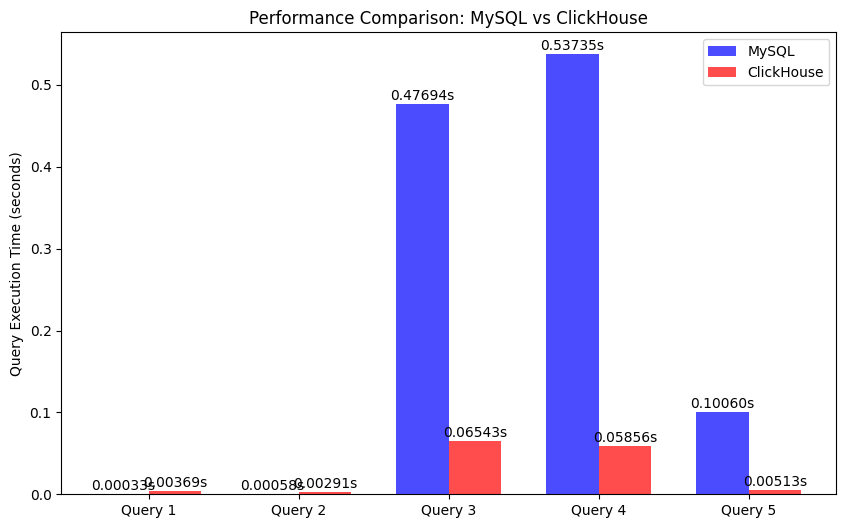

In [35]:
# Script 6: Visualization of Query Performance for All 5 Queries
query_labels = ["Query 1", "Query 2", "Query 3", "Query 4", "Query 5"]
mysql_times = [mysql_time_1, mysql_time_2, mysql_time_3, mysql_time_4, mysql_time_5]
clickhouse_times = [clickhouse_time_1, clickhouse_time_2, clickhouse_time_3, clickhouse_time_4, clickhouse_time_5]

x = np.arange(len(query_labels))  # Label positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, mysql_times, width, label='MySQL', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, clickhouse_times, width, label='ClickHouse', color='red', alpha=0.7)

ax.set_ylabel('Query Execution Time (seconds)')
ax.set_title('Performance Comparison: MySQL vs ClickHouse')
ax.set_xticks(x)
ax.set_xticklabels(query_labels)
ax.legend()

# Annotate bars with values
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.5f}s', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.5f}s', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

plt.show()

## Comparaison 4 : Requête avec jointure

In [37]:
data = [(1, 0, 0.0),
        (2, 1, 1.0),
        (3, 2, 3.5),
        (5, 3, 6.0),
        (8, 4, 10.5)]

In [38]:
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS special_rule;")

cursor.execute("""
    CREATE TABLE special_rule (
        id INT PRIMARY KEY,
        passenger INT,
        reduction FLOAT
    );
""")

conn.commit()

for row in data:
    cursor.execute("""
        INSERT INTO special_rule (id, passenger, reduction)
        VALUES (%s, %s, %s)
    """, row)

conn.commit()
cursor.close()

client.command("DROP TABLE IF EXISTS special_rule;")

client.command("""
    CREATE TABLE special_rule (
        id UInt32,
        passenger UInt8,
        reduction Float32
    ) ENGINE = MergeTree()
    ORDER BY id;
""")

client.insert("special_rule", data)

In [39]:
resultsql = sql_query("SELECT * FROM special_rule")
print(resultsql)
resultcol = client.query("SELECT * FROM special_rule")
print(resultcol.result_rows)

[(1, 0, 0.0), (2, 1, 1.0), (3, 2, 3.5), (5, 3, 6.0), (8, 4, 10.5)]
[(1, 0, 0.0), (2, 1, 1.0), (3, 2, 3.5), (5, 3, 6.0), (8, 4, 10.5)]


Join Query - MySQL Time:      0.86681 seconds
Join Query - ClickHouse Time: 0.08885 seconds


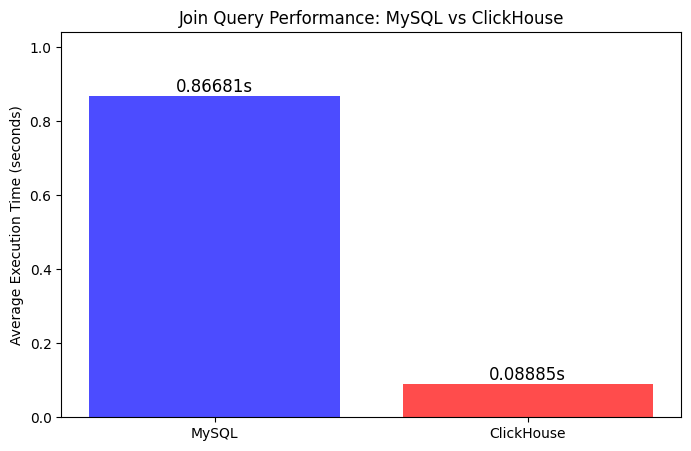

In [41]:
query_join = "SELECT * FROM nyc_taxi JOIN special_rule ON nyc_taxi.passenger_count = special_rule.passenger WHERE tip_amount < 10 * fare_amount"
iterations = 25

t0_mysql_join = time.time()
for _ in range(iterations):
    resultsql = sql_query(query_join)
t1_mysql_join = time.time()
mysql_join_time = (t1_mysql_join - t0_mysql_join) / iterations

t0_clickhouse_join = time.time()
for _ in range(iterations):
    resultcol = client.query(query_join)
t1_clickhouse_join = time.time()
clickhouse_join_time = (t1_clickhouse_join - t0_clickhouse_join) / iterations

print("Join Query - MySQL Time:      {:.5f} seconds".format(mysql_join_time))
print("Join Query - ClickHouse Time: {:.5f} seconds".format(clickhouse_join_time))

databases = ["MySQL", "ClickHouse"]
times_join = [mysql_join_time, clickhouse_join_time]

plt.figure(figsize=(8, 5))
plt.bar(databases, times_join, color=['blue', 'red'], alpha=0.7)
plt.ylabel("Average Execution Time (seconds)")
plt.title("Join Query Performance: MySQL vs ClickHouse")
plt.ylim(0, max(times_join) * 1.2)
plt.text(0, mysql_join_time, f"{mysql_join_time:.5f}s", ha='center', va='bottom', fontsize=12)
plt.text(1, clickhouse_join_time, f"{clickhouse_join_time:.5f}s", ha='center', va='bottom', fontsize=12)
plt.show()

En conclusion, le columnar est plus pertinent pour les données analytiques ou historiques (informatique décisionnelle) qui ont besoin d'être lues rapidement et en grands volumes, qui sont peu modifiées ou agrégées. Ce paradigme est également recommandé pour les requêtes impliquant un nombre limité de colonnes ou un grand nombre de lignes. Enfin cela permet un requêtage plus performant, un meilleur taux de compression et de partition des données.

À l'inverse, pour des bases de données transactionnelles, avec de nombreux ajouts et mises à jour de données avec une grande variabilité et de multiples colonnes, le columnar est peu approprié et présente des performances décevantes voire rédhibitoires.

Pour tirer profit au maximum des atouts de chaque paradigme, en ligne ou en colonne, il est possible d'hybrider les technologies, comme c'est le cas sur les projets Snowflake ou Google Big Query.